In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

In [2]:
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version: ", tf.__version__)

# Print details of the GPU if available
gpu_devices = tf.config.list_physical_devices('GPU')
for gpu in gpu_devices:
    print(gpu)

Num GPUs Available:  0
TensorFlow version:  2.18.0


In [3]:
#if using google drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd


# Load the unscaled datasets
train_df = pd.read_csv('/content/drive/MyDrive/Differential PCA, rough volatility models and financial time series/Data/Data_used/train_data_scaled_final.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Differential PCA, rough volatility models and financial time series/Data/Data_used/test_data_scaled_final.csv')


# Display the first few rows of the datasets to understand their structure
train_df.head(), test_df.head()

(     Input1    Input2    Input3    Input4    Input5  Input_Differential1  \
 0  0.316779  0.290322  0.249748  0.199288  0.144579            -0.170795   
 1  0.290322  0.249748  0.199288  0.144579  0.090377            -0.269180   
 2  0.249748  0.199288  0.144579  0.090377  0.039753            -0.354035   
 3  0.199288  0.144579  0.090377  0.039753 -0.005742            -0.404305   
 4  0.144579  0.090377  0.039753 -0.005742 -0.045751            -0.418090   
 
    Input_Differential2  Input_Differential3  Input_Differential4   Output1  \
 0            -0.269180            -0.354035            -0.404305  0.090377   
 1            -0.354035            -0.404305            -0.418090  0.039753   
 2            -0.404305            -0.418090            -0.404948 -0.005742   
 3            -0.418090            -0.404948            -0.375963 -0.045751   
 4            -0.404948            -0.375963            -0.340247 -0.080814   
 
    ...  Output_Differential1  Output_Differential2  Output_

## Load and Format Data

In [5]:
# Extracting inputs and outputs for training
X_train_original = train_df[['Input1', 'Input2', 'Input3', 'Input4', 'Input5']].values.reshape(-1, 5, 1)
X_train_diff = train_df[['Input_Differential1', 'Input_Differential2', 'Input_Differential3', 'Input_Differential4']].values.reshape(-1, 4, 1)

# Outputs
# Identify the output columns (assuming they are named Output1, Output2, ..., Output10)
output_columns = [f'Output{i+1}' for i in range(10)]

# Extract Y_train for original outputs using the identified columns
Y_train_original = train_df[output_columns].values
Y_train_diff = train_df[[col for col in train_df.columns if 'Output_Differential' in col]].values

# Reshape the test data in the same way
X_test_original = test_df[['Input1', 'Input2', 'Input3', 'Input4', 'Input5']].values.reshape(-1, 5, 1)
X_test_diff = test_df[['Input_Differential1', 'Input_Differential2', 'Input_Differential3', 'Input_Differential4']].values.reshape(-1, 4, 1)

# Extract the test ground truth outputs (original and differential)
Y_test_original = test_df[['Output1', 'Output2', 'Output3', 'Output4', 'Output5',
                                       'Output6', 'Output7', 'Output8', 'Output9', 'Output10']].values
Y_test_diff = test_df[[col for col in test_df.columns if 'Output_Differential' in col]].values

# Confirming the shapes
X_train_original.shape, X_train_diff.shape, Y_train_original.shape, Y_train_diff.shape, X_test_original.shape, X_test_diff.shape, Y_test_original.shape, Y_test_diff.shape

((580, 5, 1),
 (580, 4, 1),
 (580, 10),
 (580, 10),
 (387, 5, 1),
 (387, 4, 1),
 (387, 10),
 (387, 10))

## Custom-Loss Function

In [6]:
# ************Using Custom Loss Functions*********
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model
import numpy as np
import time

def rmse(y_true, y_pred):
    error = np.subtract(y_pred, y_true)
    sqerror = np.sum(np.square(error)) / y_true.shape[0]
    return np.sqrt(sqerror)

def MODEL_twin_LSTM(x_train_original, x_train_diff, x_test_original, x_test_diff,
                    y_train_original, y_train_diff, y_test_original, y_test_diff,
                    Num_Exp, n_steps_in, n_steps_out, Epochs, Hidden):
    n_features = 1

    # Reshape the data for LSTM input
    x_train_original = x_train_original.reshape((x_train_original.shape[0], x_train_original.shape[1], n_features))
    x_train_diff = x_train_diff.reshape((x_train_diff.shape[0], x_train_diff.shape[1], n_features))
    x_test_original = x_test_original.reshape((x_test_original.shape[0], x_test_original.shape[1], n_features))
    x_test_diff = x_test_diff.reshape((x_test_diff.shape[0], x_test_diff.shape[1], n_features))

    # Initialize arrays to store results from experiments
    train_acc_original = np.zeros(Num_Exp)
    train_acc_diff = np.zeros(Num_Exp)
    test_acc_original = np.zeros(Num_Exp)
    test_acc_diff = np.zeros(Num_Exp)
    Step_RMSE_original = np.zeros([Num_Exp, n_steps_out])
    Step_RMSE_diff = np.zeros([Num_Exp, n_steps_out])

    Best_RMSE = 1000  # Assigning a large initial number

    # Define the model outside the loop (reusing the model across experiments)
    input_original = Input(shape=(n_steps_in, n_features), name='input_original')
    input_diff = Input(shape=(n_steps_in - 1, n_features), name='input_diff')

    # Shared LSTM layer
    shared_lstm = LSTM(units=Hidden, activation='tanh', return_sequences=False, name='shared_lstm')

    # Process inputs through the shared LSTM layer
    original_lstm_output = shared_lstm(input_original)
    diff_lstm_output = shared_lstm(input_diff)

    # Concatenate the LSTM outputs
    combined_output = Concatenate()([original_lstm_output, diff_lstm_output])

    # Predict outputs using the combined LSTM outputs
    output_original = Dense(units=n_steps_out, activation='linear', name='output_original')(combined_output)
    output_diff = Dense(units=n_steps_out, activation='linear', name='output_diff')(combined_output)

    # Define the model
    model = Model(inputs=[input_original, input_diff], outputs=[output_original, output_diff])

    # Define the optimizer outside the loop
    optimizer = tf.keras.optimizers.Adam()

    # Define custom loss functions for each output
    def custom_loss_original(y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))

    def custom_loss_diff(y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))

    # Assign custom losses to each output
    losses = {
        'output_original': custom_loss_original,
        'output_diff': custom_loss_diff
    }

    # Optionally, assign loss weights
    loss_weights = {
        'output_original': 0.5,
        'output_diff': 0.5
    }

    # Compile the model once before the loop using custom loss functions
    model.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights)

    # Print model summary to ensure architecture is correct
    model.summary()

    start_time = time.time()
    for run in range(Num_Exp):
        print(f"Experiment {run + 1} in progress")

        # Train the model
        history = model.fit(
            x=[x_train_original, x_train_diff],
            y=[y_train_original, y_train_diff],
            epochs=Epochs,
            batch_size=32,
            verbose=0,
            shuffle=False
        )

        # Print loss after training
        final_loss = history.history['loss'][-1]
        print(f"Final loss for experiment {run + 1}: {final_loss}")

        # Predict on training and testing sets
        y_predicttrain_original, y_predicttrain_diff = model.predict([x_train_original, x_train_diff])
        y_predicttest_original, y_predicttest_diff = model.predict([x_test_original, x_test_diff])

        # Calculate RMSE for training and test sets (both original and differential)
        train_acc_original[run] = rmse(y_train_original, y_predicttrain_original)
        train_acc_diff[run] = rmse(y_train_diff, y_predicttrain_diff)
        test_acc_original[run] = rmse(y_test_original, y_predicttest_original)
        test_acc_diff[run] = rmse(y_test_diff, y_predicttest_diff)

        # Update the best RMSE and save the best predictions
        if test_acc_original[run] < Best_RMSE:
            Best_RMSE = test_acc_original[run]
            Best_Predict_Test = [y_predicttest_original, y_predicttest_diff]

        # Calculate RMSE for each step in the predicted sequence on the test data
        for j in range(n_steps_out):
            Step_RMSE_original[run][j] = rmse(y_test_original[:, j], y_predicttest_original[:, j])
            Step_RMSE_diff[run][j] = rmse(y_test_diff[:, j], y_predicttest_diff[:, j])

    print("Total time for", Num_Exp, "experiments:", time.time() - start_time)
    return train_acc_original, train_acc_diff, test_acc_original, test_acc_diff, Step_RMSE_original, Step_RMSE_diff, Best_Predict_Test

# Example usage of the function
train_acc_original, train_acc_diff, test_acc_original, test_acc_diff, Step_RMSE_original, Step_RMSE_diff, Best_Predict_Test = MODEL_twin_LSTM(
    x_train_original=X_train_original,
    x_train_diff=X_train_diff,
    x_test_original=X_test_original,
    x_test_diff=X_test_diff,
    y_train_original=Y_train_original,
    y_train_diff=Y_train_diff,
    y_test_original=Y_test_original,
    y_test_diff=Y_test_diff,
    Num_Exp=30,
    n_steps_in=5,
    n_steps_out=10,
    Epochs=1000,  # Consider reducing epochs to prevent overfitting
    Hidden=10
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_original            │ (None, 5, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_diff (InputLayer)   │ (None, 4, 1)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ shared_lstm (LSTM)        │ (None, 10)             │            480 │ input_original[0][0],  │
│                           │                        │                │ input_diff[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 20)             │              0 │ shared_lstm[0][0],     │
│                           │                        │                │ shared_lstm[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_original (Dense)   │ (None, 10)             │            210 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_diff (Dense)       │ (None, 10)             │            210 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 900 (3.52 KB)

 Trainable params: 900 (3.52 KB)

 Non-trainable params: 0 (0.00 B)

Experiment 1 in progress
Final loss for experiment 1: 0.0019043509382754564
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Experiment 2 in progress
Final loss for experiment 2: 0.001184140215627849
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Experiment 3 in progress
Final loss for experiment 3: 0.0007627742015756667
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Experiment 4 in progress
Final loss for experiment 4: 0.00053339300211519
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Experiment 5 in progress
Final loss for experiment 5: 0.0004413125279825181
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Experiment 6 in progress
Final loss for experiment 6: 0.0003940689784940332
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Experiment 7 in progress
Final loss for experiment 7: 0.00036277546

## Results

In [7]:
import numpy as np
import pandas as pd

def prepare_and_save_results(train_acc_original, test_acc_original, Step_RMSE_original,
                             train_acc_diff, test_acc_diff, Step_RMSE_diff,
                             Num_Exp, n_steps_out, name):

    # Combine results for tabular display for original series
    arr_original = np.dstack((train_acc_original, test_acc_original))
    arr_original = arr_original.reshape(Num_Exp, 2)
    arr_original = np.concatenate((arr_original, Step_RMSE_original), axis=1)
    arr_original = arr_original.reshape(Num_Exp, 2 + n_steps_out)

    # Combine results for tabular display for differential series
    arr_diff = np.dstack((train_acc_diff, test_acc_diff))
    arr_diff = arr_diff.reshape(Num_Exp, 2)
    arr_diff = np.concatenate((arr_diff, Step_RMSE_diff), axis=1)
    arr_diff = arr_diff.reshape(Num_Exp, 2 + n_steps_out)

    ExpIndex = np.array(["Exp" + str(j + 1) for j in range(Num_Exp)])
    ExpIndex1 = ['TrainRMSE', 'TestRMSE'] + ["Step" + str(j + 1) for j in range(n_steps_out)]

    arr_original_df = pd.DataFrame(np.round_(arr_original, decimals=5), index=ExpIndex, columns=ExpIndex1)
    arr_diff_df = pd.DataFrame(np.round_(arr_diff, decimals=5), index=ExpIndex, columns=ExpIndex1)

    print("Original Series Results:")
    print(arr_original_df)
    print("\nDifferential Series Results:")
    print(arr_diff_df)

    # # Save to CSV
    # arr_original_df.to_csv(f"Results/{name}/ExpAnalysis_Original.csv")
    # arr_diff_df.to_csv(f"Results/{name}/ExpAnalysis_Differential.csv")

    return arr_original_df, arr_diff_df



In [8]:
def calculate_and_save_statistics(arr_original_df, arr_diff_df, train_acc_original, test_acc_original,
                                  train_acc_diff, test_acc_diff, Step_RMSE_original, Step_RMSE_diff,
                                  Num_Exp, n_steps_out, name):

    # Function to calculate statistics for a given array
    def calculate_statistics(train_acc, test_acc, Step_RMSE, n_steps_out, Num_Exp):
        Train_Mean = np.mean(train_acc)
        Train_Std = np.std(train_acc)
        Train_CI_LB = Train_Mean - 1.96 * (Train_Std / np.sqrt(Num_Exp))
        Train_CI_UB = Train_Mean + 1.96 * (Train_Std / np.sqrt(Num_Exp))

        Test_Mean = np.mean(test_acc)
        Test_Std = np.std(test_acc)
        Test_CI_LB = Test_Mean - 1.96 * (Test_Std / np.sqrt(Num_Exp))
        Test_CI_UB = Test_Mean + 1.96 * (Test_Std / np.sqrt(Num_Exp))

        arr1 = np.vstack((
            [Train_Mean, Train_Std, Train_CI_LB, Train_CI_UB, np.min(train_acc), np.max(train_acc)],
            [Test_Mean, Test_Std, Test_CI_LB, Test_CI_UB, np.min(test_acc), np.max(test_acc)]
        ))

        for j in range(n_steps_out):
            Step_mean = np.mean(Step_RMSE[:, j])
            Step_std = np.std(Step_RMSE[:, j])
            Step_min = np.min(Step_RMSE[:, j])
            Step_CI_LB = Step_mean - 1.96 * (Step_std / np.sqrt(Num_Exp))
            Step_CI_UB = Step_mean + 1.96 * (Step_std / np.sqrt(Num_Exp))
            arr1 = np.vstack((arr1, [Step_mean, Step_std, Step_CI_LB, Step_CI_UB, Step_min, np.max(Step_RMSE[:, j])]))

        return pd.DataFrame(np.round_(arr1, decimals=5), index=arr_original_df.columns,
                            columns=['Mean', 'Standard Deviation', 'CI_LB', 'CI_UB', 'Min', 'Max'])

    # Calculate statistics for original and differential series
    stats_original_df = calculate_statistics(train_acc_original, test_acc_original, Step_RMSE_original, n_steps_out, Num_Exp)
    stats_diff_df = calculate_statistics(train_acc_diff, test_acc_diff, Step_RMSE_diff, n_steps_out, Num_Exp)

    print("\nOriginal Series Summary:")
    print(stats_original_df)
    print("\nDifferential Series Summary:")
    print(stats_diff_df)

    # # Save to CSV
    # stats_original_df.to_csv(f"Results/{name}/OverallAnalysis_Original.csv")
    # stats_diff_df.to_csv(f"Results/{name}/OverallAnalysis_Differential.csv")

    return stats_original_df, stats_diff_df


In [9]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(Best_Predict_Test, y_test_original, y_test_diff, n_steps_out, name):

    # Plot actual vs predicted for original series
    x_data = np.linspace(0, y_test_original.shape[0], num=y_test_original.shape[0])
    for j in range(n_steps_out):
        plt.figure()
        plt.plot(x_data, y_test_original[:, j], label='actual')
        plt.plot(x_data, Best_Predict_Test[0][:, j], label='predicted')
        plt.ylabel('Value')
        plt.xlabel('Time (samples)')
        plt.title(f'Original Series: Actual vs Predicted (Step {j+1})')
        plt.legend()
        # plt.savefig(f"Results/{name}/pred_Step{j+1}_Original.png", dpi=300)
        plt.show()
        plt.close()

    # Plot actual vs predicted for differential series
    x_data = np.linspace(0, y_test_diff.shape[0], num=y_test_diff.shape[0])
    for j in range(n_steps_out):
        plt.figure()
        plt.plot(x_data, y_test_diff[:, j], label='actual')
        plt.plot(x_data, Best_Predict_Test[1][:, j], label='predicted')
        plt.ylabel('Value')
        plt.xlabel('Time (samples)')
        plt.title(f'Differential Series: Actual vs Predicted (Step {j+1})')
        plt.legend()
        # plt.savefig(f"Results/{name}/pred_Step{j+1}_Differential.png", dpi=300)
        plt.show()
        plt.close()



In [10]:
def plot_rmse_means(stats_original_df, stats_diff_df, n_steps_out, name):

    # Plot TrainRMSE and TestRMSE for original series
    plt.figure(figsize=(10, 6))
    plt.bar(['TrainRMSE(Mean)', 'TestRMSE(Mean)'],
            stats_original_df['Mean'][:2], yerr=stats_original_df['Standard Deviation'][:2], capsize=5)
    plt.title('Original Series: Train and Test RMSE Mean with Standard Deviation')
    plt.ylabel('RMSE')
    # plt.savefig(f"Results/{name}/RMSE_Mean_Original.png", dpi=300)
    plt.show()

    # Plot TrainRMSE and TestRMSE for differential series
    plt.figure(figsize=(10, 6))
    plt.bar(['TrainRMSE(Mean)', 'TestRMSE(Mean)'],
            stats_diff_df['Mean'][:2], yerr=stats_diff_df['Standard Deviation'][:2], capsize=5)
    plt.title('Differential Series: Train and Test RMSE Mean with Standard Deviation')
    plt.ylabel('RMSE')
    # plt.savefig(f"Results/{name}/RMSE_Mean_Differential.png", dpi=300)
    plt.show()

    # Plot Step-wise RMSE Mean for original series
    plt.figure(figsize=(12, 6))
    plt.bar([f'Step{j+1}' for j in range(n_steps_out)],
            stats_original_df['Mean'][2:], yerr=stats_original_df['Standard Deviation'][2:], capsize=5)
    plt.title('Original Series: Step-wise RMSE Mean with Standard Deviation')
    plt.ylabel('RMSE')
    plt.xlabel('Steps')
    # plt.savefig(f"Results/{name}/Step_RMSE_Mean_Original.png", dpi=300)
    plt.show()

    # Plot Step-wise RMSE Mean for differential series
    plt.figure(figsize=(12, 6))
    plt.bar([f'Step{j+1}' for j in range(n_steps_out)],
            stats_diff_df['Mean'][2:], yerr=stats_diff_df['Standard Deviation'][2:], capsize=5)
    plt.title('Differential Series: Step-wise RMSE Mean with Standard Deviation')
    plt.ylabel('RMSE')
    plt.xlabel('Steps')
    # plt.savefig(f"Results/{name}/Step_RMSE_Mean_Differential.png", dpi=300)
    plt.show()

<ipython-input-11-e456baf66d1f>:8: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  arr_original_df, arr_diff_df = prepare_and_save_results(
<ipython-input-11-e456baf66d1f>:8: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  arr_original_df, arr_diff_df = prepare_and_save_results(
<ipython-input-8-3152937568f1>:34: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  stats_original_df = calculate_statistics(train_acc_original, test_acc_original, Step_RMSE_original, n_steps_out, Num_Exp)
<ipython-input-8-3152937568f1>:35: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  stats_diff_df = calculate_statistics(train_acc_diff, test_acc_diff, Step_RMSE_diff, n_steps_out, Num_Exp)


Original Series Results:
       TrainRMSE  TestRMSE    Step1    Step2    Step3    Step4    Step5  \
Exp1     0.11563   0.11986  0.00599  0.00887  0.01400  0.02195  0.03033   
Exp2     0.08864   0.09401  0.00356  0.00623  0.01127  0.01822  0.02559   
Exp3     0.06874   0.07299  0.00466  0.00570  0.00909  0.01430  0.02016   
Exp4     0.05732   0.06120  0.00490  0.00541  0.00769  0.01193  0.01619   
Exp5     0.05203   0.05586  0.00498  0.00535  0.00711  0.01065  0.01453   
Exp6     0.04813   0.05196  0.00500  0.00517  0.00664  0.00955  0.01321   
Exp7     0.04618   0.05002  0.00501  0.00505  0.00651  0.00934  0.01289   
Exp8     0.04423   0.04813  0.00463  0.00489  0.00651  0.00928  0.01280   
Exp9     0.04246   0.04635  0.00419  0.00474  0.00646  0.00916  0.01266   
Exp10    0.04095   0.04467  0.00389  0.00454  0.00627  0.00887  0.01227   
Exp11    0.03954   0.04300  0.00365  0.00433  0.00605  0.00859  0.01175   
Exp12    0.03783   0.04103  0.00348  0.00414  0.00581  0.00831  0.01124   


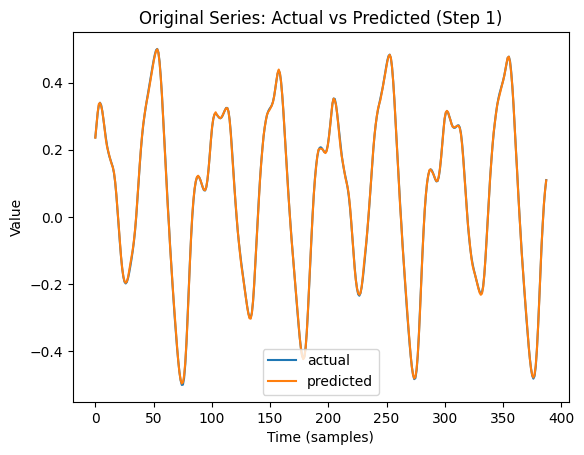

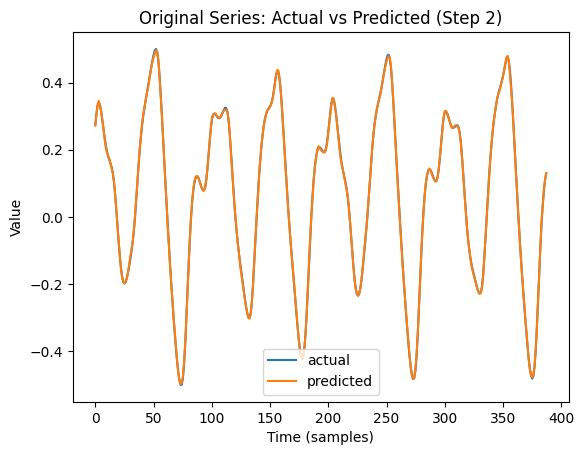

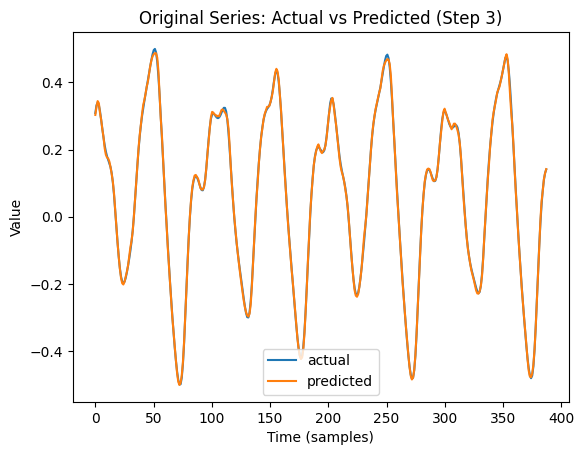

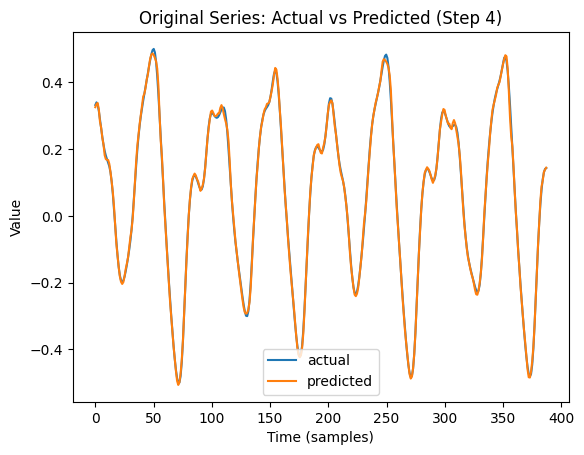

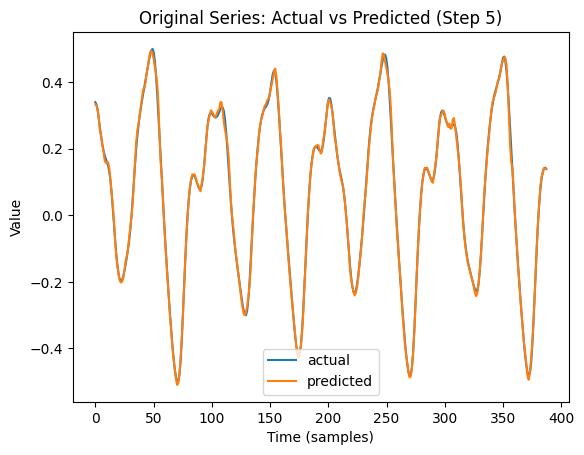

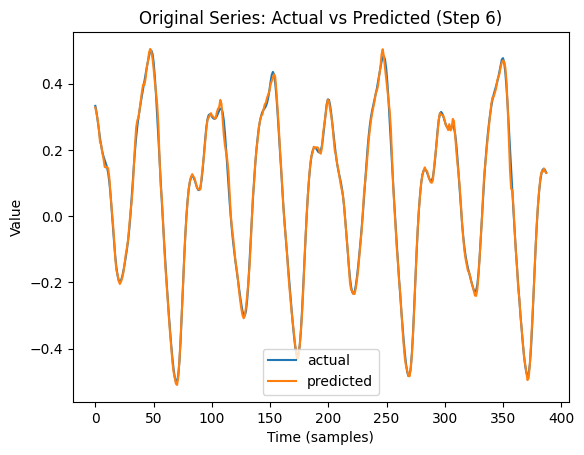

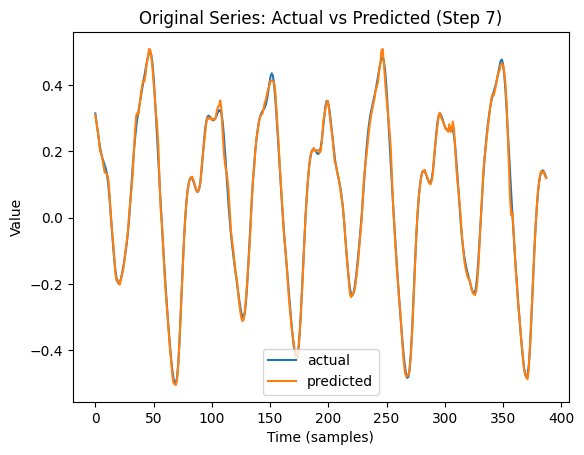

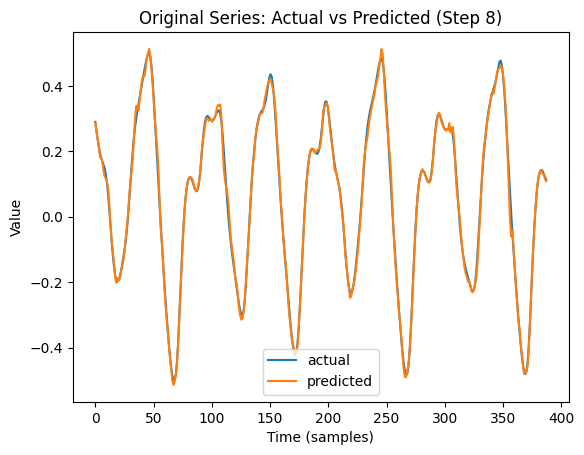

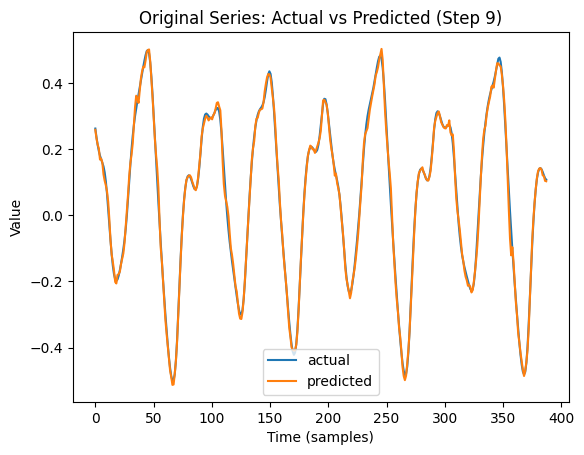

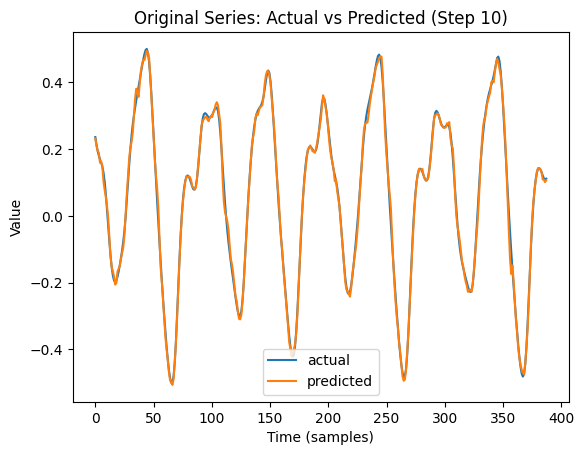

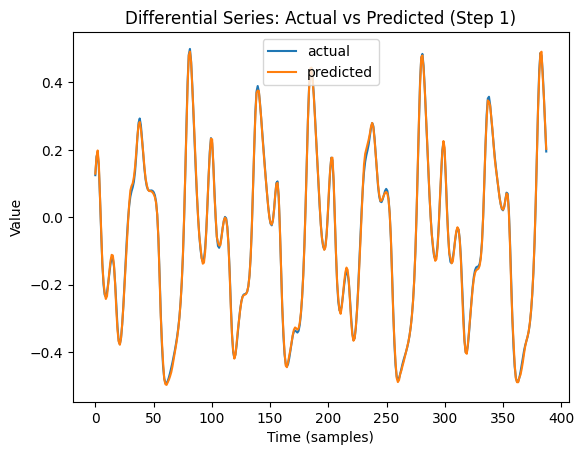

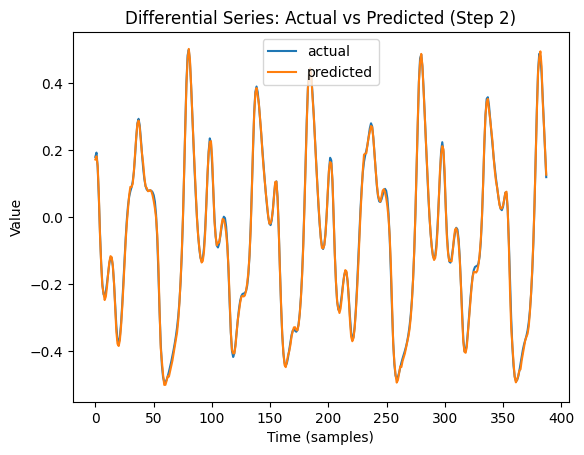

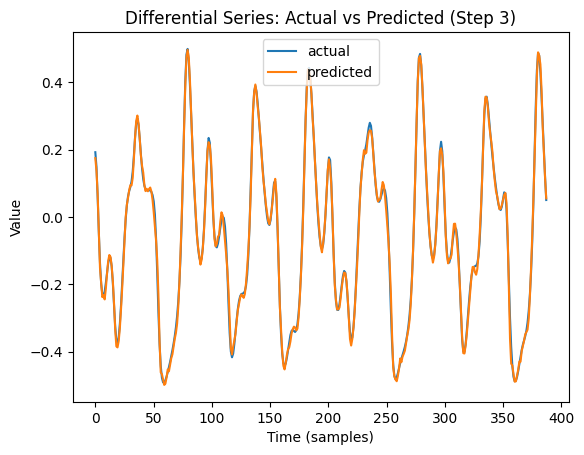

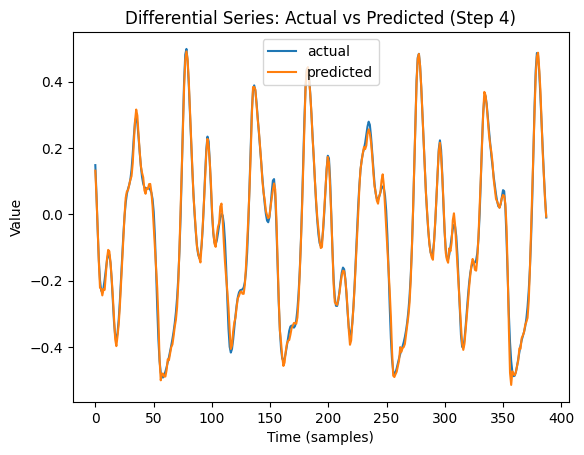

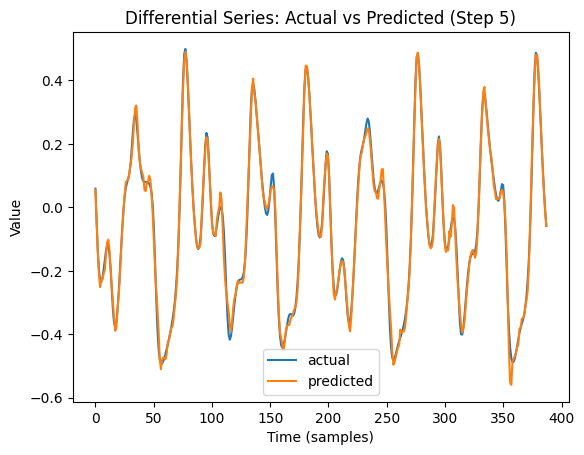

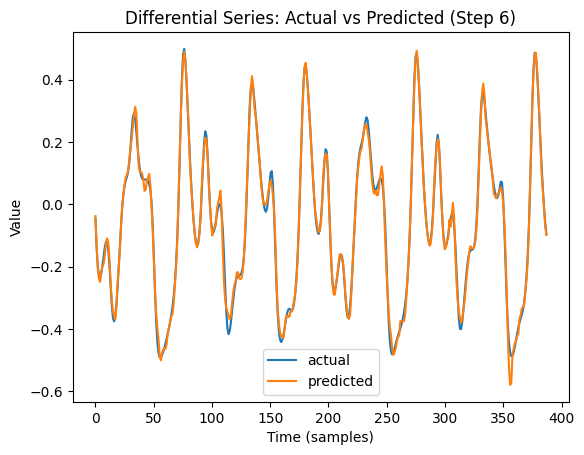

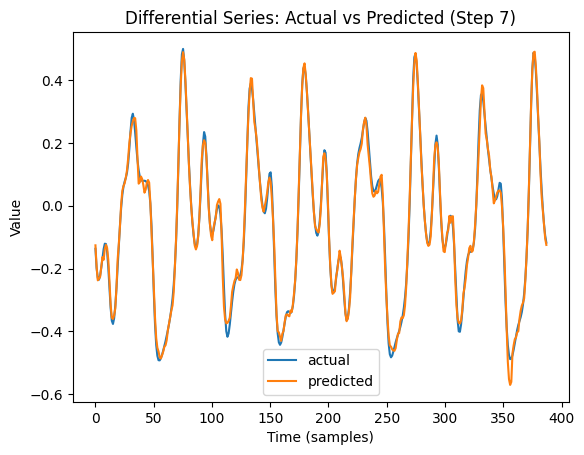

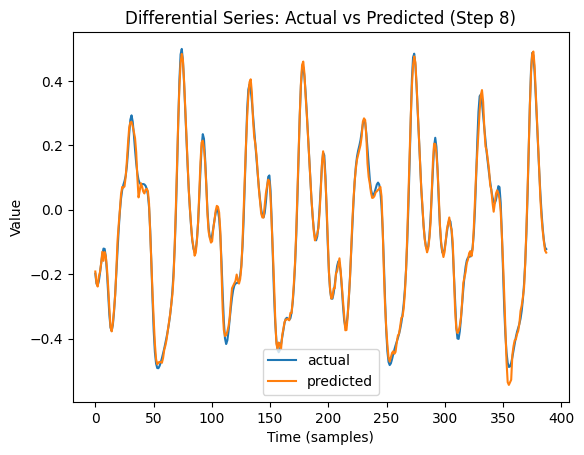

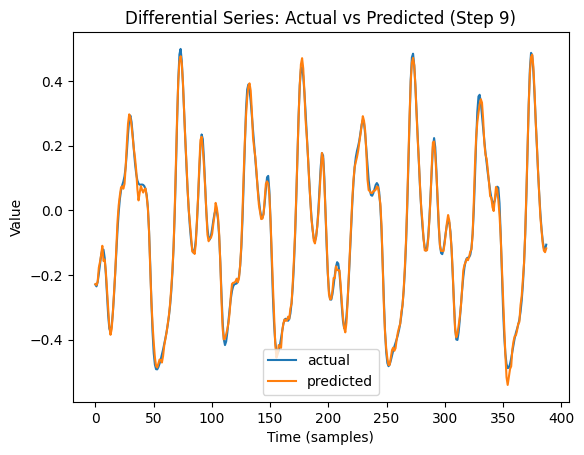

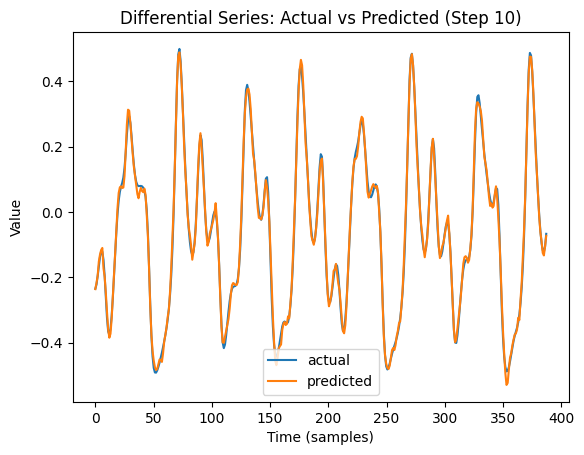

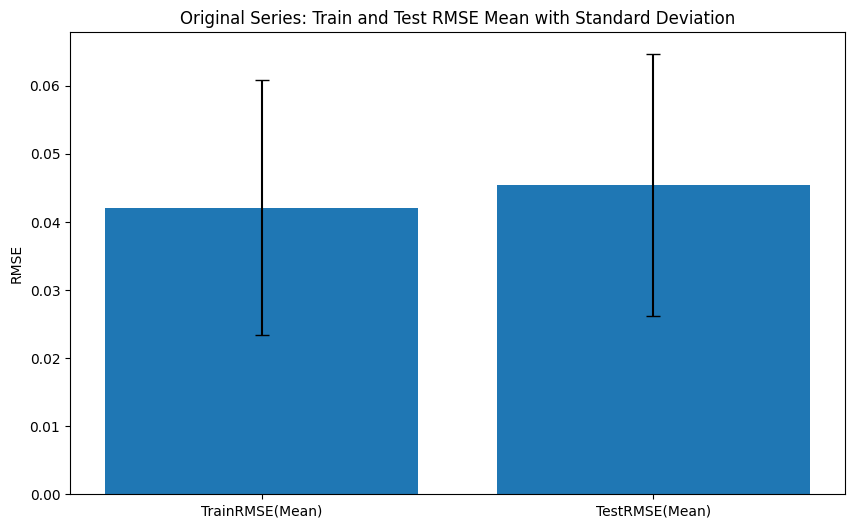

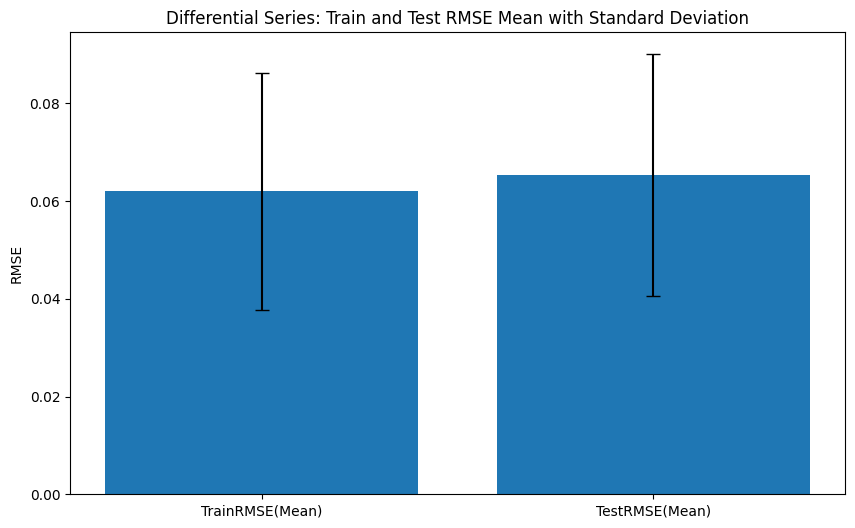

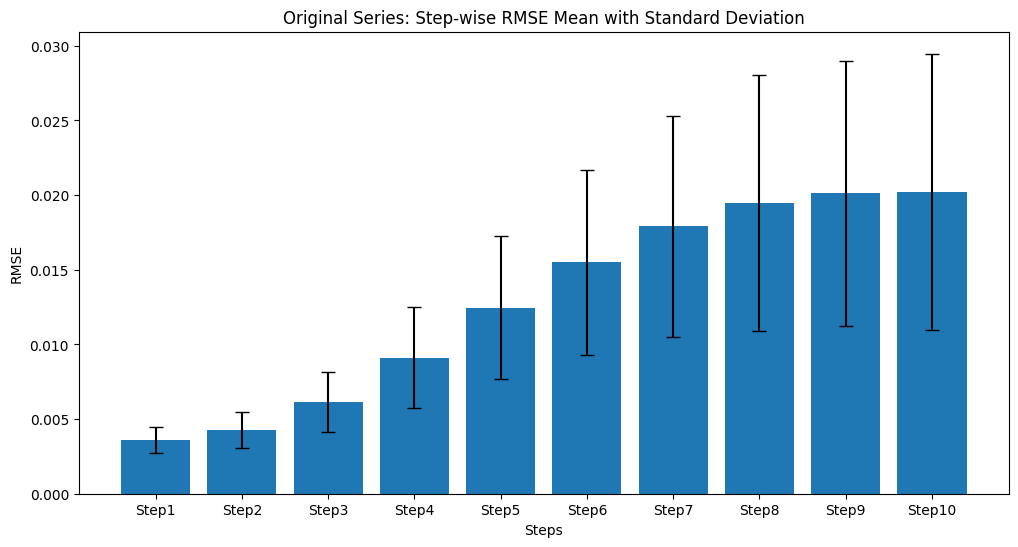

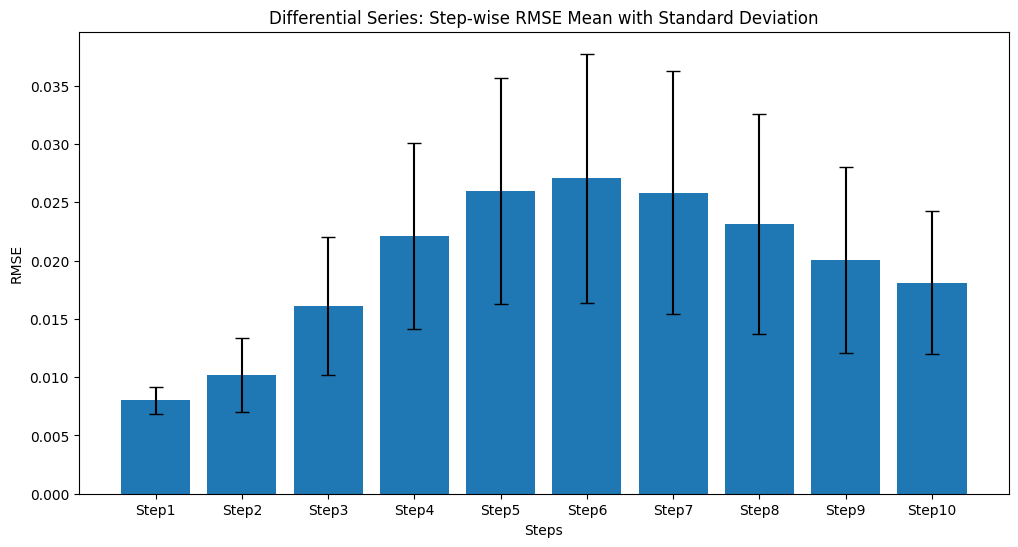

In [11]:
# Complete process
def analyze_and_visualize_results(train_acc_original, test_acc_original, Step_RMSE_original,
                                  train_acc_diff, test_acc_diff, Step_RMSE_diff,
                                  Best_Predict_Test, y_test_original, y_test_diff,
                                  Num_Exp, n_steps_out, name):

    # Prepare and save results
    arr_original_df, arr_diff_df = prepare_and_save_results(
        train_acc_original, test_acc_original, Step_RMSE_original,
        train_acc_diff, test_acc_diff, Step_RMSE_diff,
        Num_Exp, n_steps_out, name
    )

    # Calculate and save statistics
    stats_original_df, stats_diff_df = calculate_and_save_statistics(
        arr_original_df, arr_diff_df,
        train_acc_original, test_acc_original,
        train_acc_diff, test_acc_diff,
        Step_RMSE_original, Step_RMSE_diff,
        Num_Exp, n_steps_out, name
    )

    # Plot actual vs predicted values
    plot_actual_vs_predicted(Best_Predict_Test, Y_test_original, Y_test_diff, n_steps_out, name)

    # Plot RMSE mean and step-wise RMSE mean
    plot_rmse_means(stats_original_df, stats_diff_df, n_steps_out, name)

# Example usage:
analyze_and_visualize_results(train_acc_original, test_acc_original, Step_RMSE_original,
                              train_acc_diff, test_acc_diff, Step_RMSE_diff,
                              Best_Predict_Test, Y_test_original, Y_test_diff,
                              Num_Exp=30, n_steps_out=10, name="Mackey_Glass")
